In [1]:
from langchain_ollama import ChatOllama, OllamaEmbeddings
from dotenv import load_dotenv
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_core.tools import tool
from langgraph.graph import StateGraph, START
from typing import Annotated, TypedDict
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage, BaseMessage
from langgraph.prebuilt import ToolNode, tools_condition

load_dotenv()

True

In [2]:
model_llama = ChatOllama(model="llama3")
model_qween = ChatOllama(model="qwen3:4b")
model_gemma = ChatOllama(model="gemma3")

In [3]:
loader = PyPDFLoader("intro-to-ml.pdf")
docs = loader.load()

In [4]:
len(docs)

392

In [5]:
splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
chunks = splitter.split_documents(docs)

In [6]:
len(chunks)

973

In [7]:
embeddings = OllamaEmbeddings(model='mxbai-embed-large')
vector_store = FAISS.from_documents(chunks, embeddings)

In [ ]:
vector_store

In [8]:
retriever = vector_store.as_retriever(search_type='similarity', search_kwargs={'k':4})

In [9]:
@tool
def rag_tool(query):

    """
    Retrieve relevant information from the pdf document.
    Use this tool when the user asks factual / conceptual questions
    that might be answered from the stored documents.
    """
    result = retriever.invoke(query)

    context = [doc.page_content for doc in result]
    metadata = [doc.metadata for doc in result]

    return {
        'query': query,
        'context': context,
        'metadata': metadata
    }

In [10]:
tools = [rag_tool]
llm_with_tools = model_qween.bind_tools(tools)

In [11]:
class ChatState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]

In [12]:
def chat_node(state: ChatState):

    messages = state['messages']

    response = llm_with_tools.invoke(messages)

    return {'messages': [response]}

In [13]:
tool_node = ToolNode(tools)

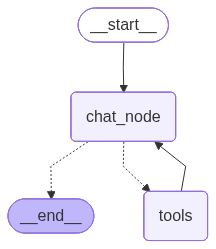

In [15]:
graph = StateGraph(ChatState)

graph.add_node('chat_node', chat_node)
graph.add_node('tools', tool_node)

graph.add_edge(START, 'chat_node')
graph.add_conditional_edges('chat_node', tools_condition)
graph.add_edge('tools', 'chat_node')

chatbot = graph.compile()
chatbot

In [16]:
result = chatbot.invoke(
    {
        "messages": [
            HumanMessage(
                content=(
                    "Using the pdf notes, explain how to find the ideal value of K in KNN"
                )
            )
        ]
    }
)

In [17]:
print(result['messages'][-1].content)

Okay, let me try to figure out how to answer the user's question about finding the ideal K value in KNN using the provided PDF notes.

First, I need to recall what the user is asking. They want to know how to determine the best K value for the K-Nearest Neighbors algorithm based on the pdf notes. The tool response from the rag_tool gives some context from the PDF, so I should parse that information.

Looking at the context from the tool response:

The PDF excerpts mention that KNN uses a parameter 'n_neighbors' which is the number of neighbors to consider. The example shows setting n_neighbors=1 in the code. The text also talks about the model's performance, like the test set score being 0.97. 

Wait, but the user is asking about finding the ideal K, not just how to set it. The context here seems to be from a tutorial on KNN in "Introduction to Machine Learning with Python" by Andreas Müller and Sarah Guido. The specific part mentions that the KNN classifier's parameter n_neighbors is 